In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from blending.utils.dataset import ImageDataBlending
from blending.utils.image import (_pil_image, get_image_laplacian_operator, get_blending_gradients,
                                  get_mixing_gradients, normalize_image)
from blending.utils.plots import plots_multiple_image_data, plots_multiple_tensor_image
from blending.models import VGG16_Model, MeanShift
from blending import blend
from argparse import Namespace
from tqdm.auto import tqdm
from IPython.display import Image

In [35]:
opt = Namespace(
    data_dir = 'data_blending',
    normalize = True,
    requires_grad = True,
    device = 'cuda',
    image_index = 1,
)

device = torch.device(opt.device)
image_index = opt.image_index

# Load Data

In [36]:
image_data_blending = ImageDataBlending(opt.data_dir, normalize=opt.normalize, device=device)

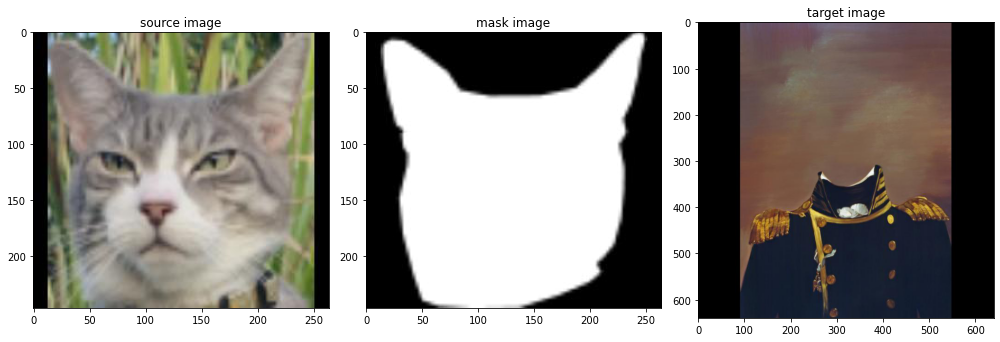

In [37]:
plots_multiple_image_data(image_data_blending[image_index], normalize=opt.normalize)

# Laplacian Operator

Laplacian operator $\nabla I$ over the image:

$$
\nabla = \begin{bmatrix}
     0 & -1 & 0 \\
     -1 & 4 & -1 \\
     0 & -1 & 0
\end{bmatrix}
$$

In order to get the gradients of the images, we are going to define a convolutinal operation using the `laplacian matrix` as the kernel. Then make a convolution between the image, $I$, and the kernel $\nabla$

$$\begin{bmatrix}
     0 & -1 & 0 \\
     -1 & 4 & -1 \\
     0 & -1 & 0
\end{bmatrix} \circledast I$$

The following code will calculate each channel's gradients, and present it as plots 

## Gradients of source image

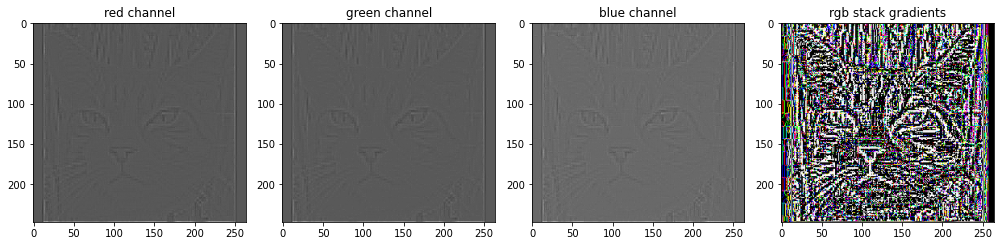

In [38]:
# Show each channel gradient
rgb_gradients_list = get_image_laplacian_operator(image_data_blending[image_index]['source'].unsqueeze(0), device=device)
rgb_gradients = torch.stack(rgb_gradients_list, dim=2).view(*image_data_blending[image_index]['source'].shape)
plots_multiple_tensor_image(*rgb_gradients_list, np.asarray(_pil_image(rgb_gradients)),
                            title_name=["red channel", "green channel", "blue channel", "rgb stack gradients"],
                           normalize=opt.normalize)

## Gradients of target image

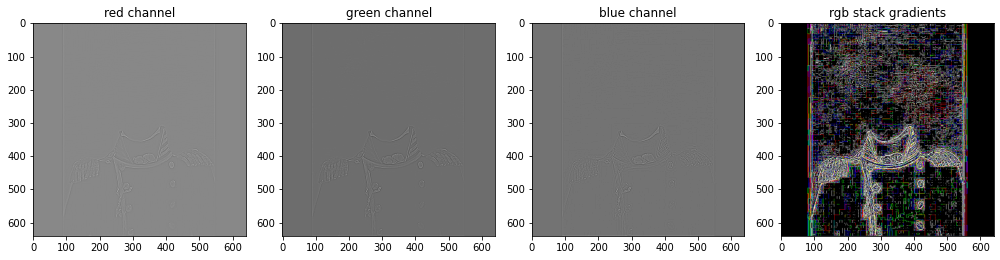

In [39]:
# Show each channel gradient
rgb_gradients_list = get_image_laplacian_operator(image_data_blending[image_index]['target'].unsqueeze(0), device=device)
rgb_gradients = torch.stack(rgb_gradients_list, dim=2).view(*image_data_blending[image_index]['target'].shape)
plots_multiple_tensor_image(*rgb_gradients_list, np.asarray(_pil_image(rgb_gradients)),
                            title_name=["red channel", "green channel", "blue channel", "rgb stack gradients"],
                            normalize=opt.normalize)

# Join Gradients

As we are going to blend both images `source` and `target`, we need to mix its gradients in order to optimize the following loss function:

$$L_{grad} = \frac{1}{2HW} \sum_{m=1}^{H}\sum_{n=1}^{W}[\nabla f(I_B) - (\nabla f(I_S) + \nabla f(I_T)]^{2}_{mn}$$

where $f$ is the blending function, $\nabla$ the laplacian operator, $I_S$ the source image and $I_T$ the target image. This loss function is over the gradients that means we are going to create a image such that optimize the previous loss grad

## Content loss function

For this content loss function we are going to use pretrained model VGG on imagenet, and this is define as:

$$L_{cont} = \sum_{l=1}^{L}\frac{\alpha_l}{2N_lM_l}\sum_{i=1}^{N_l}\sum_{k=1}^{M_l}(F_l[I_{Z} \odot M ] - F_l[I_{S} \odot M ])^{2}_{ik}$$

where $I_Z$ is the random Image that we are going to optimize, and $I_S$ is the source image. But the only layer we are going to use is the second activation layer before `MaxPool2d`

## TV (total variation) loss

The total variation (tv) loss is used to remove the un-wanted details while preserving the import information in the image. The loss objective is shown below.

$$L_{tv} = \sum_{m=1}^{H}\sum_{n=1}^{W}(|I_{m+1,n}-I_{m,n}| + |I_{m,n+1}-I_{m,n}|)$$

where $I$ is the blend image.

In the original implementation they use `MeanShift` module but with some experiments I see that normalizing using imagenet stats give better solutions

In [40]:
torch.cuda.empty_cache()

image_data = {
    'source': image_data_blending[image_index]['source'].unsqueeze(0),
    'target': image_data_blending[image_index]['target'].unsqueeze(0),
    'dims': image_data_blending[image_index]['dims'],
    'mask': image_data_blending[image_index]['mask'].unsqueeze(0)
}


target = image_data['target']
h, w = target.shape[2], target.shape[3]
dims = image_data['dims']

source = torch.zeros_like(target)
source[:, :, dims[0]:dims[1], dims[2]:dims[3]] = image_data['source']

mask = torch.zeros(1, 1, h, w, device=device)
mask[:,:, dims[0]:dims[1], dims[2]:dims[3]] = image_data['mask']

del image_data
torch.cuda.empty_cache()

input_img = torch.randn(*source.shape, device=device).contiguous()
input_img.requires_grad = opt.requires_grad

# tensor_image_target = target.clone()
blend_img = (input_img * mask + target * (1 - mask))
naive_copy = (source * mask + target * (1 - mask))

new_image_data = {
    "mask": mask,
    "target": target,
    "source": source,
    "dims": dims
}

# gt gradients
gt_gradients = torch.stack(get_mixing_gradients(new_image_data, device=device), dim=2).squeeze(0)
vgg16_features = VGG16_Model().to(device=device)
mean_shift = MeanShift().to(device=device)

optimizer = torch.optim.LBFGS([input_img.requires_grad_()], lr=1, max_iter=200)
mse_loss = torch.nn.MSELoss().to(device=device)

torch.cuda.empty_cache()

In [41]:
run = [0]
num_step = 1000
w_grad, w_cont, w_tv, w_style = 1e4, 1e1, 1e-6, 0.05

pbar = tqdm(total = num_step, desc = "Blending",
           position=0)
style_layers = vgg16_features.style_layers
content_layers = vgg16_features.content_layers

while run[0] < num_step:
    def closure():
        optimizer.zero_grad()
        blend_img = (input_img * mask + target * (1 - mask))
        
        # Gradient loss
        blend_gradients = torch.stack(get_blending_gradients(blend_img, device=device), dim=2).squeeze(0)
        loss_grad = w_grad * mse_loss(blend_gradients, gt_gradients)        
        
        # Content source Loss
        input_features = vgg16_features(normalize_image(blend_img))
        source_features = vgg16_features(normalize_image(source))
        loss_content = 0
        for content_layer in content_layers:
            loss_content += mse_loss(input_features[content_layer], source_features[content_layer])
        loss_content /= (len(content_layers)/w_cont)
        
        # Style source loss
        loss_source_style = 0
        for style_layer in style_layers:
            loss_source_style += mse_loss(input_features[style_layer], source_features[style_layer])
        loss_source_style /= (len(style_layers)/w_style)
        
        # TV Reg Loss
        loss_tv = w_tv * (torch.sum(torch.abs(blend_img[:, :, :, :-1] - blend_img[:, :, :, 1:])) + 
                   torch.sum(torch.abs(blend_img[:, :, :-1, :] - blend_img[:, :, 1:, :])))
            
        # colect total loss
        loss_total = loss_grad + loss_content + loss_tv + loss_source_style
            
        if (run[0] + 1)%50 == 0 or (run[0] + 1 == 1):
            with torch.no_grad():
                _pil_image(blend_img).save("results/iter_result/image_iter.jpg")
        
        
        # Backward Optimization Step
        loss_total.backward()
        
        # Update pbar
        pbar_stats = {
            "loss_grad": loss_grad.item(),
            "loss_content": loss_content.item(),
            "loss_source_style": loss_source_style.item(),
            "loss_tv": loss_tv.item(),
            "loss_total": loss_total.item()
        }
        pbar.set_postfix(**pbar_stats)
        pbar.update()
        
        
        # Update run
        run[0] += 1
        return loss_total
    
    # Optimize
    optimizer.step(closure)

## Plot results

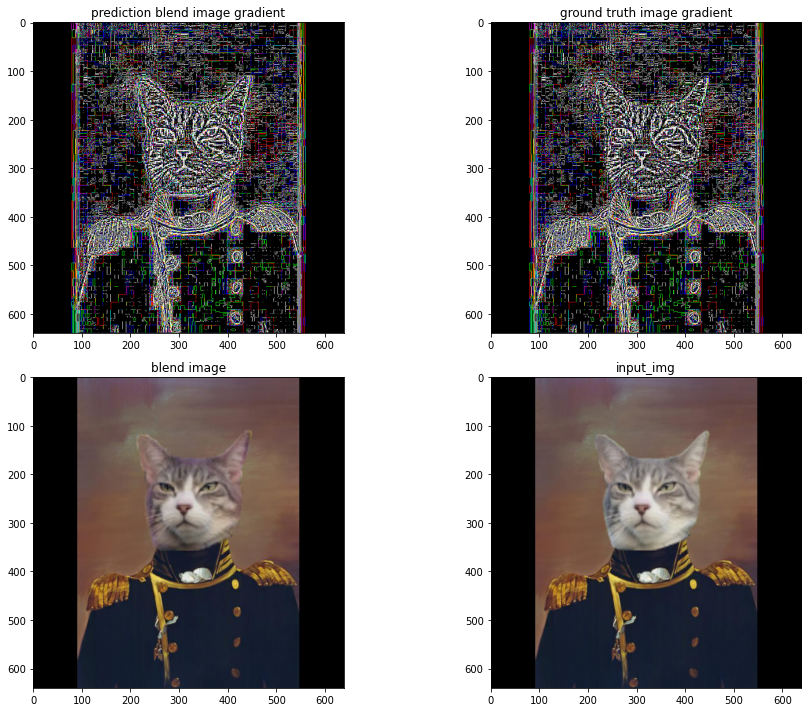

In [42]:
with torch.no_grad():
    blend_img = (input_img * mask + target * (1 - mask))
    blend_gradients = torch.stack(get_blending_gradients(blend_img, device=device), dim=2).squeeze(0)
    plots_multiple_tensor_image(np.asarray(_pil_image(blend_gradients)),
                                np.asarray(_pil_image(gt_gradients)),
                                np.asarray(_pil_image(blend_img)),
                                np.asarray(_pil_image(naive_copy)),
                                title_name=["prediction blend image gradient",
                                           "ground truth image gradient",
                                           "blend image",
                                           "input_img"], normalize=opt.normalize, ncols = 2)

# Comparation with naive copy

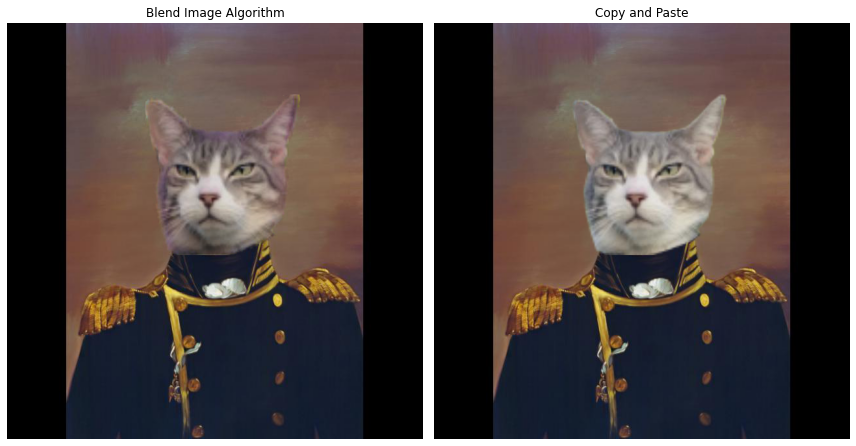

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(12, 12), tight_layout=True)

with torch.no_grad():
    ax[0].set_axis_off()
    ax[0].set_title("Blend Image Algorithm")
    ax[0].imshow(np.asarray(_pil_image(blend_img)))
    
    ax[1].set_axis_off()
    ax[1].set_title("Copy and Paste")
    ax[1].imshow(np.asarray(_pil_image(naive_copy)))
    
fig.savefig("results/comparation.jpg")